In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import itertools
import os

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

import fbprophet

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

import plotly.graph_objects as go
import plotly

plotly.offline.init_notebook_mode(connected=True)

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
logging.getLogger('pystan').setLevel(logging.ERROR)

import warnings
import sys

warnings.filterwarnings('ignore')
sys.path.append('../functions')

from tsplot import tsplot
from ur_tests import adf_test, kpss_test
from supress import suppress_stdout_stderr

figsize = (17, 8)

In [2]:
# Read dataframe
data = pd.read_csv('../data/nakazeni-vyleceni-umrti-testy-04-05.csv')
# Convert data to proper data type
data['datum'] = pd.to_datetime(data['datum'])
# Display first 5 rows
data['active'] = data['kumulativni_pocet_nakazenych'] - data['kumulativni_pocet_vylecenych'] - data['kumulativni_pocet_umrti']
data.head(5)

,datum,kumulativni_pocet_nakazenych,kumulativni_pocet_vylecenych,kumulativni_pocet_umrti,kumulativni_pocet_testu,kumulativni_pocet_ag_testu,active
0,2020-01-27,0,0,0,20,0,0
1,2020-01-28,0,0,0,28,0,0
2,2020-01-29,0,0,0,33,0,0
3,2020-01-30,0,0,0,34,0,0
4,2020-01-31,0,0,0,37,0,0


In [3]:
# Infected
infected = data[['datum', 'kumulativni_pocet_nakazenych']].rename({'kumulativni_pocet_nakazenych': 'y', 'datum': 'ds'}, axis=1)
# Cured
cured = data[['datum', 'kumulativni_pocet_vylecenych']].rename({'kumulativni_pocet_vylecenych': 'y', 'datum': 'ds'}, axis=1)
# Dead
dead = data[['datum', 'kumulativni_pocet_umrti']].rename({'kumulativni_pocet_umrti': 'y', 'datum': 'ds'}, axis=1)
# Tests
tests = data[['datum', 'kumulativni_pocet_testu']].rename({'kumulativni_pocet_testu': 'y', 'datum': 'ds'}, axis=1)
# Active = Infected - cured - dead
active = data[['datum', 'active']].rename({'active': 'y', 'datum': 'ds'}, axis=1)

### Load and plot the data 

According to ACF and PCF - ARIMA processes. Needs differencing.

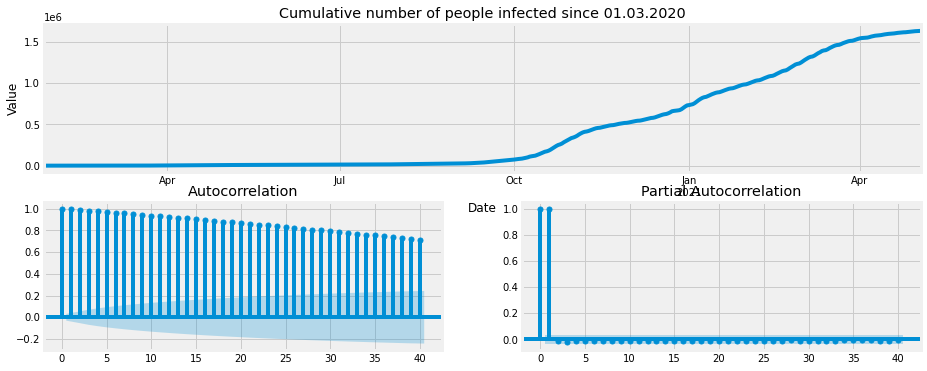

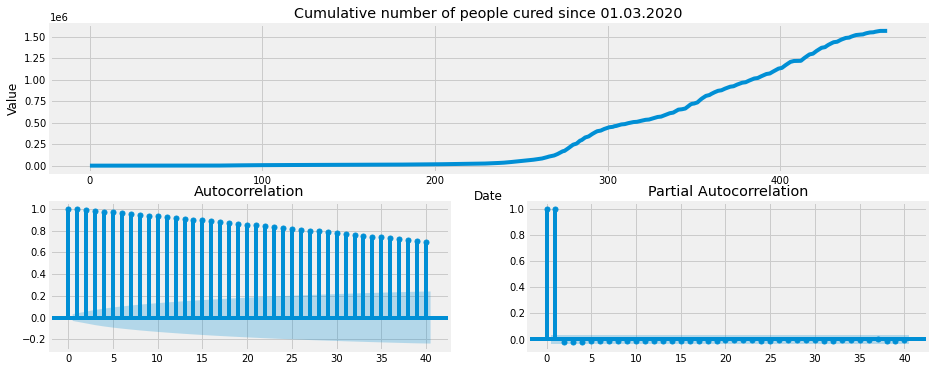

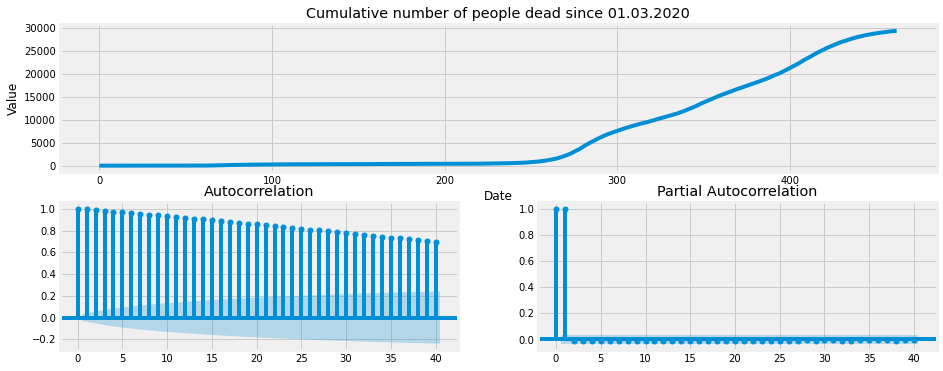

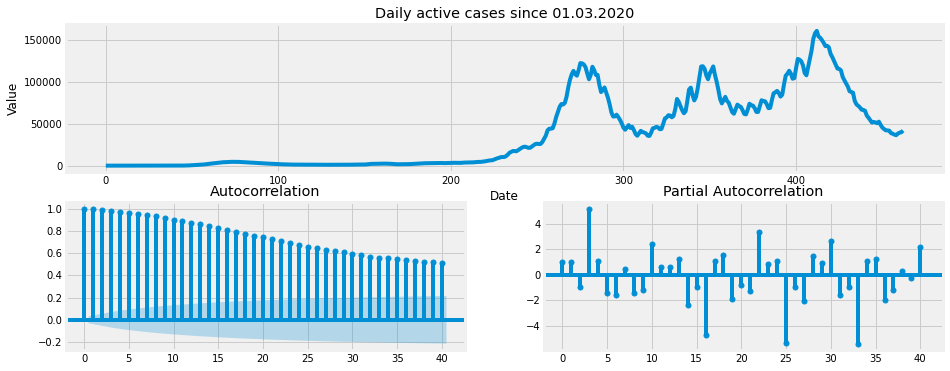

In [10]:
tsplot(infected.set_index('ds')['y'], lags=40, title='Cumulative number of people infected since 01.03.2020')
# plt.savefig('../figures/ts_orig_infected.png', dpi=150)
tsplot(cured['y'], lags=40, title='Cumulative number of people cured since 01.03.2020')
# plt.savefig('../figures/ts_orig_cured.png', dpi=150)
tsplot(dead['y'], lags=40, title='Cumulative number of people dead since 01.03.2020')
# plt.savefig('../figures/ts_orig_dead.png', dpi=150)
tsplot(active['y'], lags=40, title='Daily active cases since 01.03.2020')
# plt.savefig('../figures/ts_orig_iactive.png', dpi=150)

#### KPSS and Dickey-Fuller test on original time series

##### Infected
- Dickey-Fuller - can not reject null hypothisis
- KPSS - reject null hypothesis.

##### Cured
- Dickey-Fuller - can not reject null hypothisis
- KPSS - reject null hypothesis.

##### Dead
- Dickey-Fuller - can not reject null hypothisis
- KPSS - reject null hypothesis.

##### Active
- Dickey-Fuller - can not reject null hypothisis
- KPSS - reject null hypothesis.

In [55]:
print('Infected time series')
adf_test(infected['y'])
kpss_test(infected['y'])
print('\nCured time series')
adf_test(cured['y'])
kpss_test(cured['y'])
print('\nDead time series')
adf_test(dead['y'])
kpss_test(dead['y'])
print('\nActive time series')
adf_test(active['y'])
kpss_test(active['y'])

Infected time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                   0.932583
p-value                          0.993501
#Lags Used                      16.000000
Number of Observations Used    446.000000
Critical Value (1%)             -3.445097
Critical Value (5%)             -2.868042
Critical Value (10%)            -2.570233
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.906433
p-value                   0.010000
Lags Used                12.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


Cured time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -0.275974
p-value                          0.928839
#Lags Used                      18.000000
Num

### Differenced
##### Infected
After differecing - looks like nonstationary; Accroding to ACF seasonality with period = 7;
##### Cured
After differecing - looks like nonstationary; Accroding to ACF seasonality with period = 7; 
##### Dead
After differecing - looks like nonstationary;
##### Active
After differencing - looks like potentially stationary; According to ACF seasonality period = 7

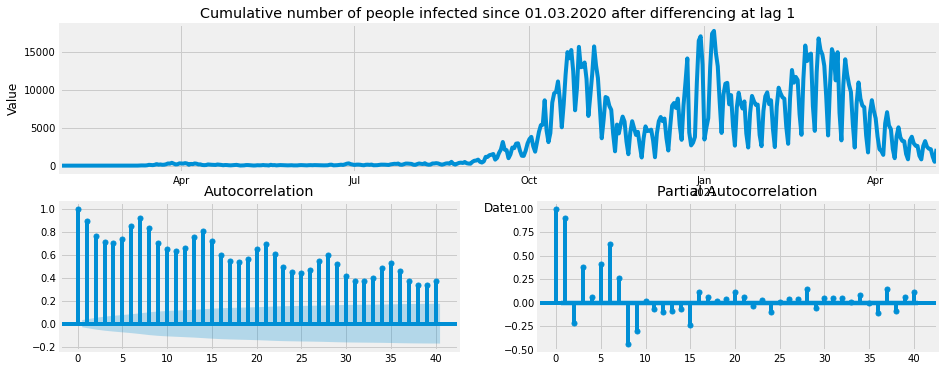

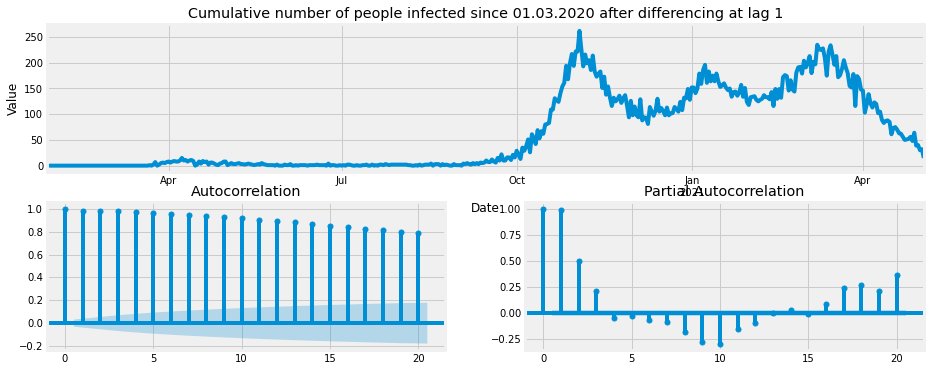

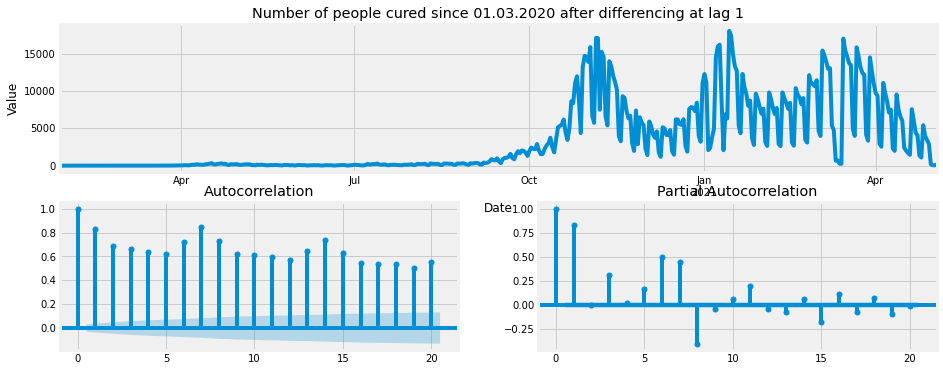

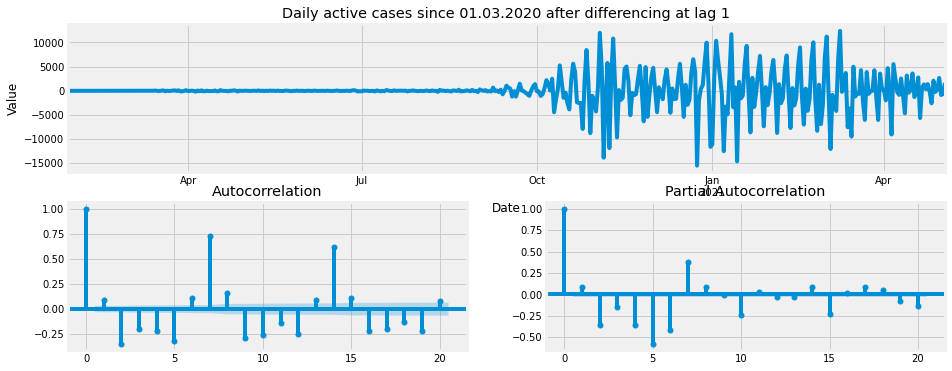

In [5]:
tsplot(infected.set_index('ds')['y'].diff().dropna(), lags=40, title='Cumulative number of people infected since 01.03.2020 after differencing at lag 1')
tsplot(dead.set_index('ds')['y'].diff().dropna(), lags=20, title='Cumulative number of people infected since 01.03.2020 after differencing at lag 1')
tsplot(cured.set_index('ds')['y'].diff().dropna(), lags=20, title='Number of people cured since 01.03.2020 after differencing at lag 1')
tsplot(active.set_index('ds')['y'].diff().diff().dropna(), lags=20, title='Daily active cases since 01.03.2020 after differencing at lag 1')
# plt.savefig('../figures/ts_diff_active.png', dpi=150)
# plt.savefig('../figures/ts_diff1_7_active.png', dpi=150)

#### KPSS and Dickey-Fuller test on differenced time series

##### Infected
- Dickey-Fuller - can not reject null hypothisis
- KPSS - reject null hypothesis.

##### Cured
- Dickey-Fuller - can not reject null hypothisis
- KPSS - reject null hypothesis.

##### Dead
- Dickey-Fuller - can not reject null hypothisis
- KPSS - reject null hypothesis.

##### Active
- Dickey-Fuller - can reject null hypothisis
- KPSS - can not reject null hypothesis.

In [56]:
print('Infected time series')
adf_test(infected['y'].diff().dropna())
kpss_test(infected['y'].diff().dropna())
print('\nCured time series')
adf_test(cured['y'].diff().dropna())
kpss_test(cured['y'].diff().dropna())
print('\nDead time series')
adf_test(dead['y'].diff().dropna())
kpss_test(dead['y'].diff().dropna())
print('\nActive time series')
adf_test(active['y'].diff().dropna())
kpss_test(active['y'].diff().dropna())

Infected time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -2.477959
p-value                          0.120930
#Lags Used                      15.000000
Number of Observations Used    446.000000
Critical Value (1%)             -3.445097
Critical Value (5%)             -2.868042
Critical Value (10%)            -2.570233
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.23061
p-value                   0.01000
Lags Used                11.00000
Critical Value (10%)      0.11900
Critical Value (5%)       0.14600
Critical Value (2.5%)     0.17600
Critical Value (1%)       0.21600
dtype: float64


Cured time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -1.980177
p-value                          0.295332
#Lags Used                      18.000000
Number of 

#### Difference 2
##### Infected
After 2nd differecing - looks like stationary; Accroding to ACF seasonality with period = 7; Needs seasonal differencing for genral part order estimation
##### Cured
After differecing - looks like stationary; Accroding to ACF seasonality with period = 7. Needs seasonal differencing for genral part order estimation
##### Dead
After differecing - looks like stationary, no trend no seasonal - According to ACF - MA(1)
##### Active
Overdifferencing - not changes

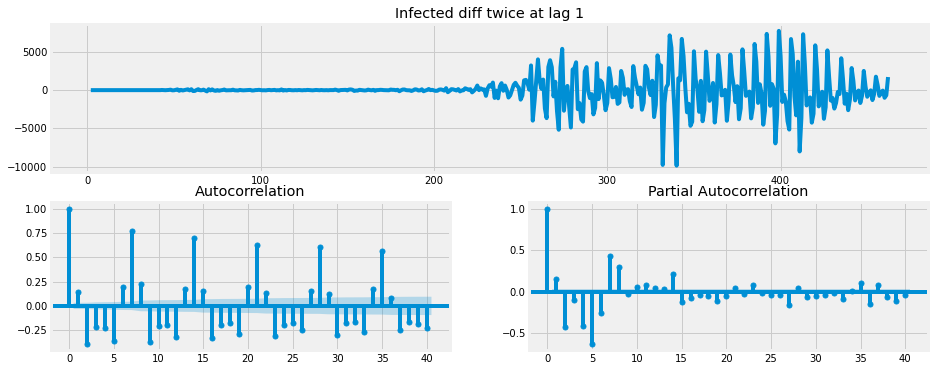

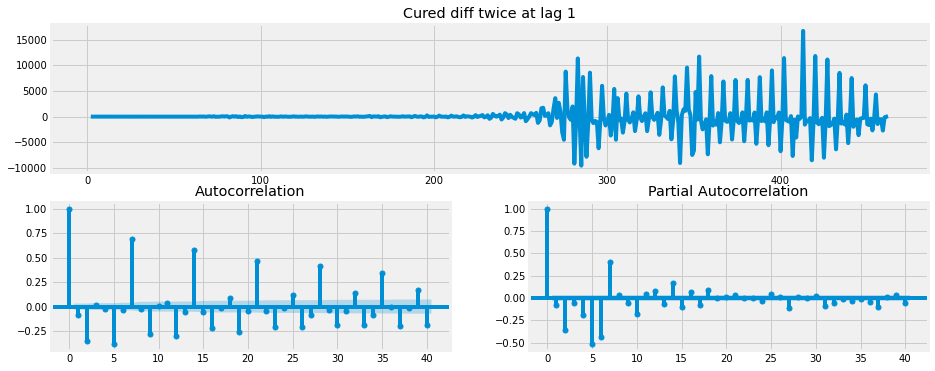

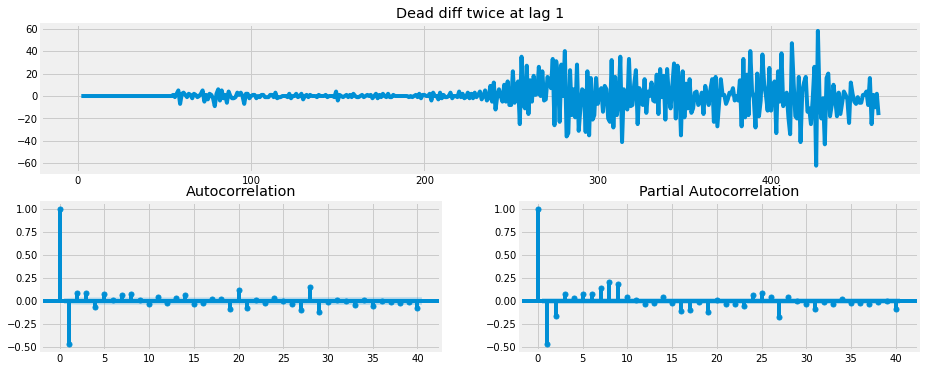

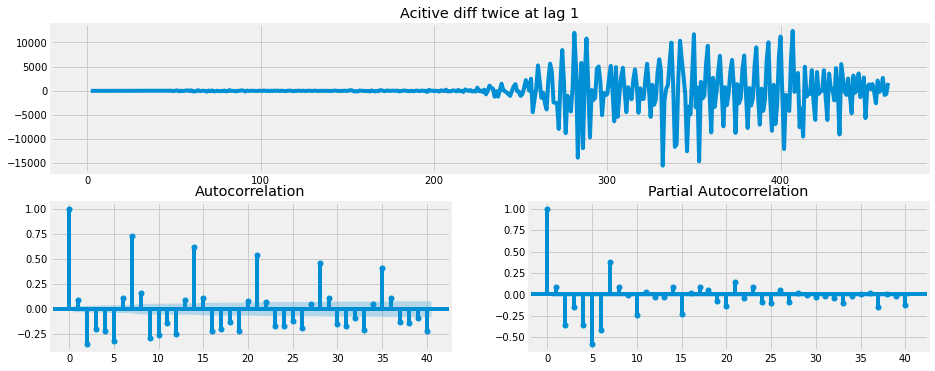

In [112]:
tsplot(infected['y'].diff().diff().dropna(), lags=40, title='Infected diff twice at lag 1')
tsplot(cured['y'].diff().diff().dropna(), lags=40, title='Cured diff twice at lag 1')
tsplot(dead['y'].diff().diff().dropna(), lags=40, title='Dead diff twice at lag 1')
tsplot(active['y'].diff().diff().dropna(), lags=40, title='Acitive diff twice at lag 1')

##### KPSS and Dickey-Fuller test on differenced twice time series
##### Infected
- Dickey-Fuller - can reject null hypothisis
- KPSS - can not reject null hypothesis.

##### Cured
- Dickey-Fuller - reject null hypothisis
- KPSS - can not reject null hypothesis.

##### Dead
- Dickey-Fuller - reject null hypothisis
- KPSS - reject null hypothesis.

##### Active
- Dickey-Fuller - can reject null hypothisis
- KPSS - can not reject null hypothesis.

In [28]:
print('Infected time series')
adf_test(infected['y'].diff().diff().dropna())
kpss_test(infected['y'].diff().diff().dropna())
print('\nCured time series')
adf_test(cured['y'].diff().diff().dropna())
kpss_test(cured['y'].diff().diff().dropna())
print('\nDead time series')
adf_test(dead['y'].diff().diff().dropna())
kpss_test(dead['y'].diff().diff().dropna())
print('\nActive time series')
adf_test(active['y'].diff().diff().dropna())
kpss_test(active['y'].diff().diff().dropna())

Infected time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -4.060831
p-value                          0.001123
#Lags Used                      14.000000
Number of Observations Used    446.000000
Critical Value (1%)             -3.445097
Critical Value (5%)             -2.868042
Critical Value (10%)            -2.570233
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.112717
p-value                   0.100000
Lags Used                88.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


Cured time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -5.008309
p-value                          0.000021
#Lags Used                      17.000000
Num

#### Seasonal differencing after 1st diff at lag 1
##### Infected
After 2nd differecing - looks like stationary
##### Cured
After differecing - looks like stationary
##### Active
After 1st differecing lag 1 + 1st at lag 7 - No trend, No seasonality; Accrding to ACF and PCF - AR(1)x(1)_7?

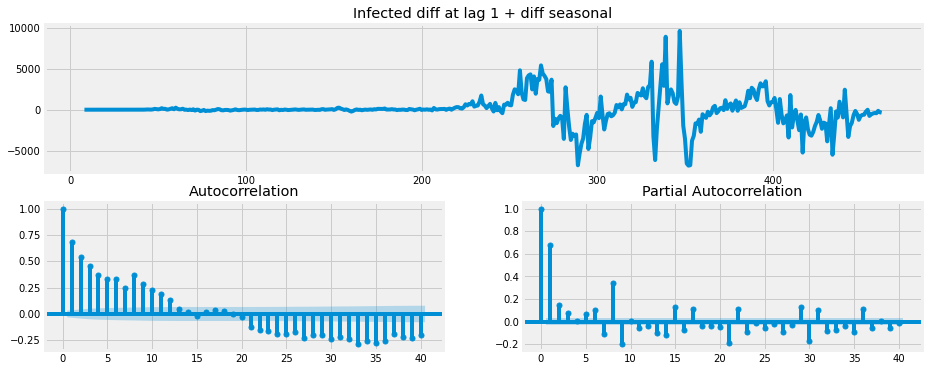

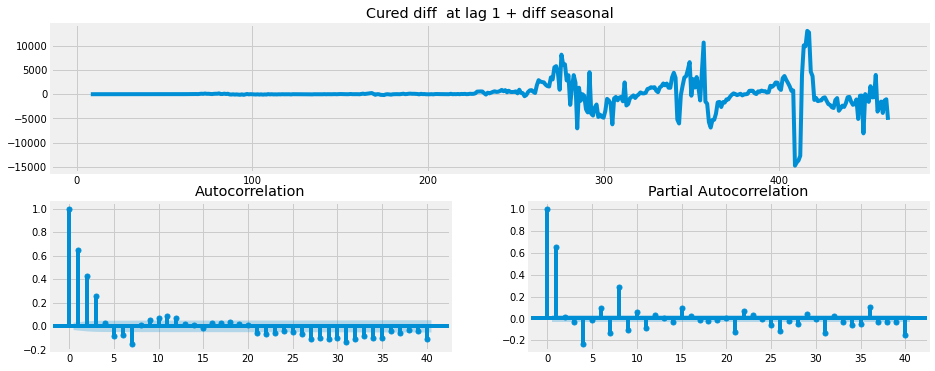

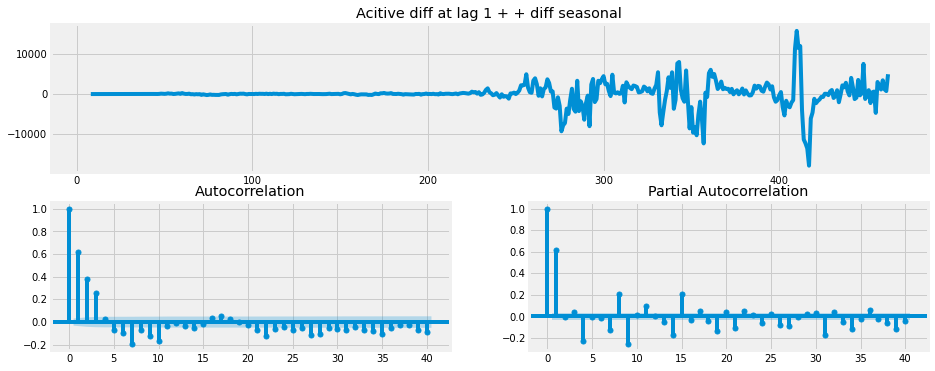

In [137]:
tsplot(infected['y'].diff().diff(7).dropna(), lags=40, title='Infected diff at lag 1 + diff seasonal')
tsplot(cured['y'].diff().diff(7).dropna(), lags=40, title='Cured diff  at lag 1 + diff seasonal')
tsplot(active['y'].diff().diff(7).dropna(), lags=40, title='Acitive diff at lag 1 + + diff seasonal')

##### KPSS and Dickey-Fuller test on differenced twice time series
##### Infected
- Dickey-Fuller - can reject null hypothisis
- KPSS - can not reject null hypothesis.

##### Cured
- Dickey-Fuller - reject null hypothisis
- KPSS - can not reject null hypothesis.

##### Active
- Dickey-Fuller - can reject null hypothisis
- KPSS - can not reject null hypothesis.

In [117]:
print('Infected time series')
adf_test(infected['y'].diff().diff(7).dropna())
kpss_test(infected['y'].diff().diff(7).dropna())
print('\nCured time series')
adf_test(cured['y'].diff().diff(7).dropna())
kpss_test(cured['y'].diff().diff(7).dropna())
print('\nActive time series')
adf_test(active['y'].diff().diff(7).dropna())
kpss_test(active['y'].diff().diff(7).dropna())

Infected time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -3.956837
p-value                          0.001654
#Lags Used                      16.000000
Number of Observations Used    438.000000
Critical Value (1%)             -3.445368
Critical Value (5%)             -2.868161
Critical Value (10%)            -2.570297
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.091382
p-value                   0.100000
Lags Used                11.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


Cured time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                -5.902924e+00
p-value                        2.750938e-07
#Lags Used                     8.000000e+

#### Seasonal differencing (at lag 7) after 2nd diff at lag 1: Infected, cured, active
##### Infected
After 2nd differecing lag 1 + 1st at lag 7 - No trend, No seasonality; Correlation at lag 1 and 7,8 - seasonal AR(1)x(1)_7?
##### Cured
After 2nd differecing lag 1 + 1st at lag 7 - No trend, No seasonality; Correlation at lag 7 - seasonal AR(1)x(1)_7?

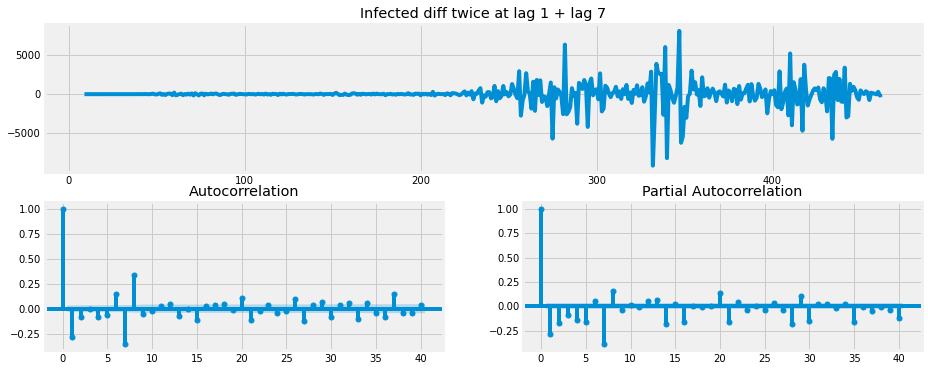

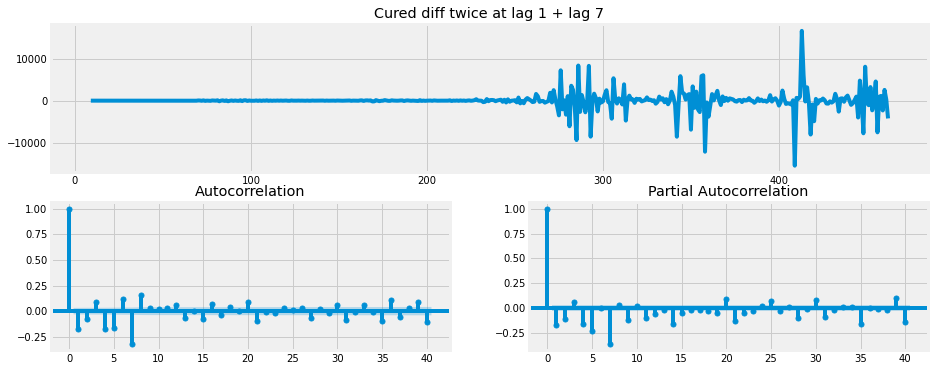

In [121]:
tsplot(infected['y'].diff().diff().diff(7).dropna(), lags=40, title='Infected diff twice at lag 1 + lag 7')
tsplot(cured['y'].diff().diff().diff(7).dropna(), lags=40, title='Cured diff twice at lag 1 + lag 7')

##### KPSS and Dickey-Fuller test on differenced twice time series
##### Infected
- Dickey-Fuller - can reject null hypothisis
- KPSS - can not reject null hypothesis.

##### Cured
- Dickey-Fuller - reject null hypothisis
- KPSS - can not reject null hypothesis.

In [122]:
print('Infected time series')
adf_test(infected['y'].diff().diff().diff(7).dropna())
kpss_test(infected['y'].diff().diff().diff(7).dropna())
print('\nCured time series')
adf_test(cured['y'].diff().diff().diff(7).dropna())
kpss_test(cured['y'].diff().diff().diff(7).dropna())

Infected time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                -7.173373e+00
p-value                        2.767265e-10
#Lags Used                     1.500000e+01
Number of Observations Used    4.380000e+02
Critical Value (1%)           -3.445368e+00
Critical Value (5%)           -2.868161e+00
Critical Value (10%)          -2.570297e+00
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.020946
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


Cured time series
Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                -9.175369e+00
p-value                        2.327960e-15
#Lags Used                 

#### Diff conclusion
##### Infected
- SARIMA(1, 2, 0)x(1, 0, 0)_7 or SARIMA(1, 1, 0)x(1, 1, 0)
##### Cured
- SARIMA(1, 2, 0)x(1, 0, 0) or SARIMA(1, 1, 0)x(1, 1, 0)
##### Dead
- ARIMA(0, 2, 1)
##### Active 
- SARIMA(1, 1, 0)x(1, 0, 0) or SARIMA(1, 1, 0)x(1, 1, 0)